# Use this notebook to try out Stability AI's Image Services on Amazon Bedrock.

Stability AI Image Services are available in four categories:
- **[Generate](#Generation)**: The best text-to-image generation services. These services leverage the latest Stable Diffusion models from Stability AI, with specialist fine-tunes and microservices embedded in workflows. Among these, Stable Image Core is the flagship service that requires no prompt engineering to get high quality images in diverse styles

    - [Stable Image Ultra](#Stable-Image-Ultra) - Stable Image Ultra creates the highest quality images with unprecedented prompt understanding. Ultra excels in typography, complex compositions, dynamic lighting, vibrant hues, and overall cohesion and structure of an art piece
    - [Stable Image Core](#Stable-Image-Core) - Stable Image Core represents the best quality achievable at high speed
    - [Stable Diffusion 3.5](#Stable-Diffusion-3.5) - 8 billion parameters, with superior quality and prompt adherence, this base model is the most powerful in the Stable Diffusion family. This model is ideal for professional use cases at 1 megapixel resolution.
      

- **[Upscale](#Upscale-Image-Services)**: Best in class image upscaling that ranges from standard conservative upscales to Creative modes that transform an image to 4k masterpieces. Among these, Creative Upscale is the flagship for creating photorealistic images from low quality inputs.

    - [Conservative Upscale](#Stable-Image-Conservative-Upscale) - Conservative Upscale minimizes alterations to the image and should not be used to reimagine an image. Takes images between 64x64 and 1 megapixel and upscales them all the way to 4K resolution
    - [Creative Upscale](#Stable-Image-Creative-Upscale) - Creative Upscale works best on highly degraded images and is not for photos of 1mp or above as it performs heavy reimagining (controlled by creativity scale). Takes images between 64x64 and 1 megapixel and upscales them all the way to 4K resolution.
    - [Fast Upscale](#Stable-Image-Fast-Upscale) - Lightweight and fast service (processing in ~1 second) is ideal for enhancing the quality of compressed images, making it suitable for social media posts and other applications. Enhances image resolution by 4x using predictive and generative AI


      

- **[Edit](#Edit-Image-Services)**: The most effective AI-based image editing services, including inpainting with masks (generative fill), or with words. Includes niche tools for product placement and advertising, as well as basic tools such as background removal.

    - [Erase](#Stable-Image-Erase) - The Erase service removes unwanted objects, such as blemishes on portraits or items on desks, using image masks.
    - [Inpaint](#Stable-Image-Inpaint) - Intelligently modify images by filling in or replacing specified areas with new content based on the content of a "mask" image.
    - [Outpaint](#Stable-Image-Outpaint) - Inserts additional content in an image to fill in the space in any direction
    - [Search and Replace](#Stable-Image-Search-and-Replace) - The Search and Replace service is a specific version of inpainting that does not require a mask. Instead, users can leverage a search_prompt to identify an object in simple language to be replaced. The service will automatically segment the object and replace it with the object requested in the prompt.
    - [Search and Recolor](#Stable-Image-Search-and-Recolor) - The Search and Recolor service provides the ability to change the color of a specific object in an image using a prompt. This service is a specific version of inpainting that does not require a mask.
    - [Remove Background](#Stable-Image-Remove-Background) - The Remove Background service accurately segments the foreground from an image and implements and removes the background.
      

- **[Control](#Control-Image-Services)**: The best image to image services. May take prompts, maps and other guides. These services leverage ControlNets and similar technologies built on Stable Diffusion models.

    - [Sketch](#Stable-Image-Sketch) - Upgrades rough hand-drawn sketches to refined outputs with precise control
    - [Structure](#Stable-Image-Structure) - Generate images by maintaining the structure of an input image, making it especially valuable for advanced content creation scenarios such as recreating scenes or rendering characters from models.
    - [Style Guide](#Stable-Image-Style-Guide) - Extracts stylistic elements from an input image (control image) and uses it to guide the creation of an output image based on the prompt.
    - [Style Transfer](#Stable-Image-Style-Transfer) - Applies visual characteristics from reference style images to target images. Helps create consistent content across multiple assets.
      

This notebook has been tested on Amazon SageMaker AI Notebook Instances and within Amazon SageMaker AI Studio.

### Pre-Requisites
1. [AWS IAM Permissions](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access-permissions.html)
1. [Amazon Bedrock Model Access](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html)
1. [Amazon SageMaker Notebook Instance](https://docs.aws.amazon.com/sagemaker/latest/dg/howitworks-create-ws.html) or [Amazon SageMaker AI](https://docs.aws.amazon.com/sagemaker/latest/dg/gs.html) or [Amazon SageMaker Unified Studio](https://docs.aws.amazon.com/sagemaker-unified-studio/latest/userguide/getting-started.html)

### Install Requirements

In [ ]:
%pip install -Uq pip
%pip install -Uq boto3

import IPython

IPython.Application.instance().kernel.do_shutdown(True)

### Import Packages

In [ ]:
import boto3
import base64
import sagemaker
import json
from IPython.display import Image, display

### SageMaker Session


In [ ]:
session = boto3.session.Session()
sagemaker_role = sagemaker.get_execution_role()
region = session.region_name

print(f'SageMaker Role: {sagemaker_role}')
print(f'Region: {region}')
print(f'Amazon Bedrock model access page: https://{region}.console.aws.amazon.com/bedrock/home?region={region}#/modelaccess')

### Stability AI Models and Stability AI Image Services on Bedrock

In [ ]:
# Generate
sd_3_5_model_id = 'stability.sd3-5-large-v1:0'
stable_core_model_id = 'stability.stable-image-core-v1:1'
stable_ultra_model_id = 'stability.stable-image-ultra-v1:1'

# Upscale
stable_image_conservative_upscale = 'us.stability.stable-conservative-upscale-v1:0'
stable_image_creative_upscale = 'us.stability.stable-creative-upscale-v1:0'
stable_image_fast_upscale = 'us.stability.stable-fast-upscale-v1:0'

# Edit
stable_image_erase_object = 'us.stability.stable-image-erase-object-v1:0'
stable_image_inpaint = 'us.stability.stable-image-inpaint-v1:0'
stable_image_outpaint = 'us.stability.stable-outpaint-v1:0'
stable_image_search_replace = 'us.stability.stable-image-search-replace-v1:0'
stable_image_search_recolor = 'us.stability.stable-image-search-recolor-v1:0'
stable_image_remove_bg = 'us.stability.stable-image-remove-background-v1:0'

# Control
stable_image_control_structure = 'us.stability.stable-image-control-structure-v1:0'
stable_image_control_sketch = 'us.stability.stable-image-control-sketch-v1:0'
stable_image_style_guide = 'us.stability.stable-image-style-guide-v1:0'
stable_image_style_transfer = 'us.stability.stable-style-transfer-v1:0'

### Python functions

In [4]:
def send_generation_request(params, model_id, region, files=None):
    """
    Send an image generation request to Amazon Bedrock.

    Args:
        params (dict): Parameters to send to the model.
        model_id (str): The Bedrock model ID.
        bedrock_client: The initialized boto3 Bedrock client.

    Returns:
        bytes: Decoded image data.

    Raises:
        Exception: If no image data is returned or another error occurs.
    """
    
    try:
        bedrock = boto3.client("bedrock-runtime", region_name=region)

        request_body = json.dumps(params)
        response = bedrock.invoke_model(modelId=model_id, body=request_body)
        model_response = json.loads(response["body"].read())
        base64_image_data = model_response.get("images", [None])[0]

        if not base64_image_data:
            raise ValueError("No image data found in model response.")

        return base64.b64decode(base64_image_data)

    except Exception as e:
        print(f"Error during image generation: {e}")
        raise

In [5]:
def create_base64_from_image(image_path):
    """
    Encodes an image file as a base64 string.

    Args:
        image_path (str): Path to the image file.

    Returns:
        str: Base64-encoded string representation of the image.

    Raises:
        Exception: If the file can't be read or encoded.
    """
    
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
        
    except Exception as e:
        print(f"Error encoding image to base64: {e}")
        raise

# Generation

### Stable Image Ultra

In [ ]:
# Stable Image Ultra

prompt = "dark high contrast render of a psychedelic tree of life illuminating dust in a mystical cave." # required {type:"string"}
negative_prompt = "" # {type:"string"}
aspect_ratio = "3:2" # ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
seed = 0 # {type:"integer"}
style_preset = "None" # ["None", "3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]
output_format = "jpeg" # ["webp", "jpeg", "png"]
image = "" # {type:"string<binary>"}
strength = 0 # [0..1]

model_id = stable_ultra_model_id
region = "us-west-2"

try:
    params = {
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "aspect_ratio": aspect_ratio,
        "seed": seed,
        "output_format": output_format
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Core

In [ ]:
# Stable Image Core

prompt = "op art cat illusion red blue chromostereopsis maximum saturation"  # required {type:"string"}
negative_prompt = ""  # {type:"string"}
aspect_ratio = "21:9"  # ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
style_preset = "None"  # ["None", "3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]
seed = 0  # [0 .. 4294967294]
output_format = "jpeg"  # ["webp", "jpeg", "png"]

model_id = stable_core_model_id
region = "us-west-2"

try:
    params = {
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "aspect_ratio": aspect_ratio,
        "seed": seed,
        "output_format": output_format
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Diffusion 3.5

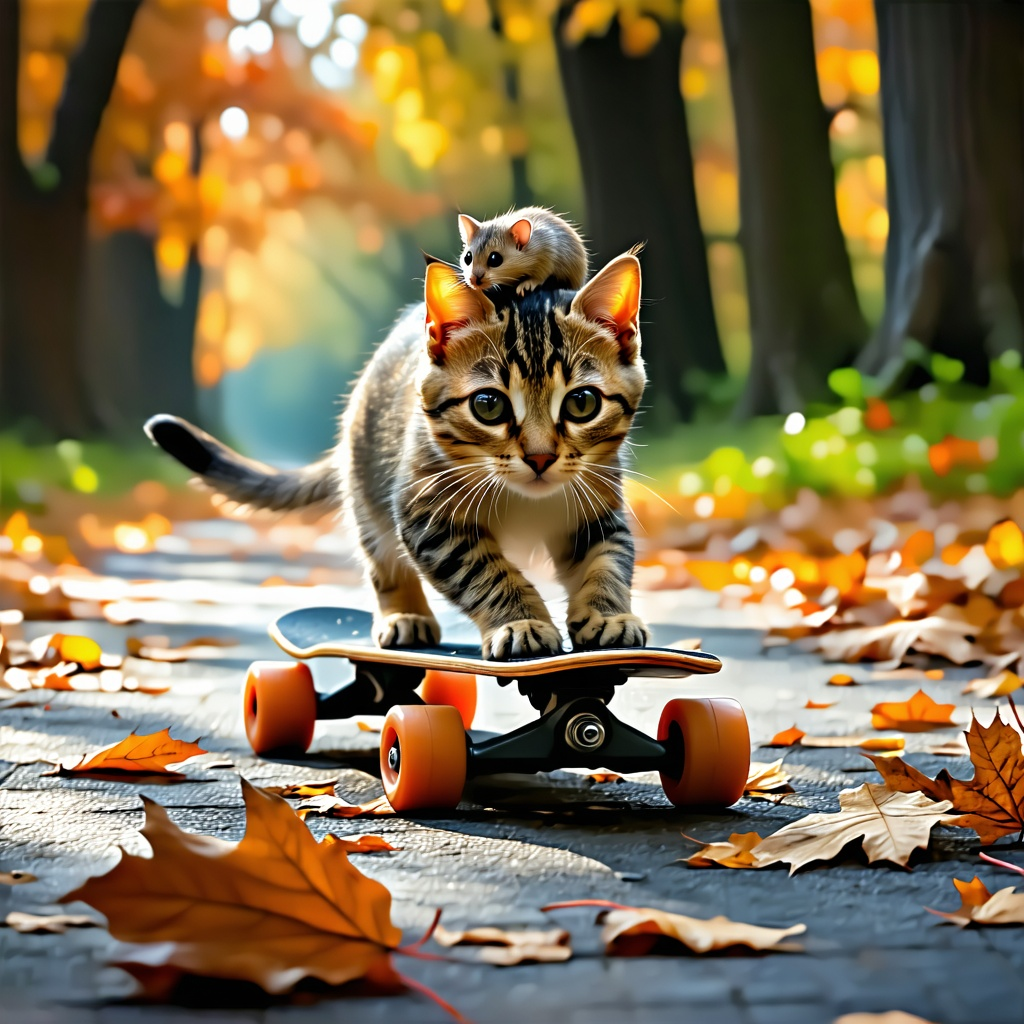

In [ ]:
# Stable Diffusion 3.5

prompt = "cinematic film still, action photo of a cat riding a skateboard through the leaves in autumn. the cat has a mouse friend resting on their head"  # required {type:"string"}
negative_prompt = ""  # {type:"string"}
aspect_ratio = "1:1"  # ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
seed = 0  # {type:"integer"}
output_format = "jpeg"  # ["jpeg", "png"]
style_preset = "None"  # ["None","3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]
strength = 1  # [0-1]
mode = "text-to-image"  # ["text-to-image", "image-to-image"]

model_id = sd_3_5_model_id
region = "us-west-2"

try:
    params = {
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "aspect_ratio": aspect_ratio,
        "seed": seed,
        "output_format": output_format,
        "mode": mode,
        "strength": strength
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    display(Image(data=generated_image))

except Exception as e:
    print(e)

# Control Image Services


Stability AI Image Services include four Control Image offerings:

- Sketch: This service offers an ideal solution for design projects that require brainstorming and frequent iterations. It upgrades rough hand-drawn sketches to refined outputs with precise control. For non-sketch images, it allows detailed manipulation of the final appearance by leveraging the contour lines and edges within the image.
- Structure: This service excels in generating images by maintaining the structure of an input image, making it especially valuable for advanced content creation scenarios such as recreating scenes or rendering characters from models.
- Style Guide: This service extracts stylistic elements from an input image (control image) and uses it to guide the creation of an output image based on the prompt. The result is a new image in the same style as the control image.
- Style Transfer: Apply visual styles from a reference image to a target image to maintain consistency across content.

### Stable Image Sketch

Original Image:


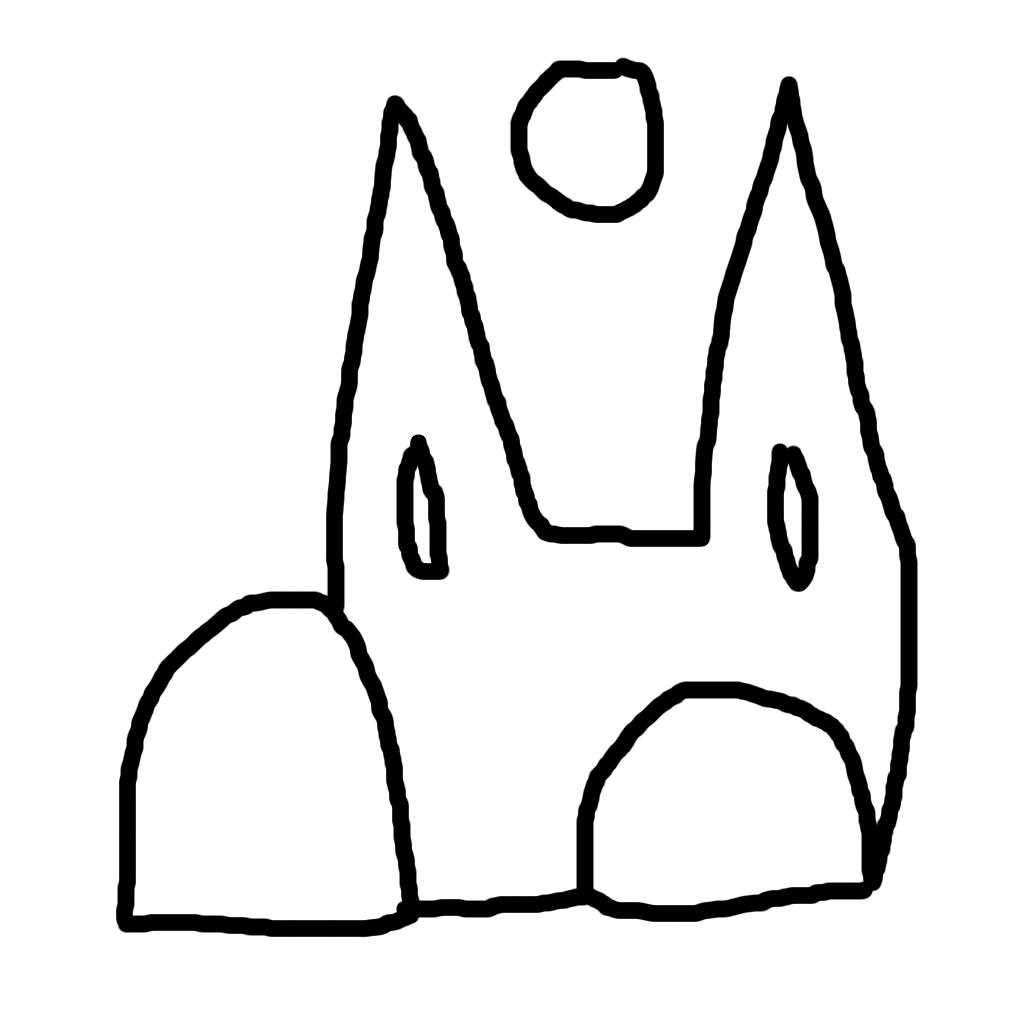

Result Image:


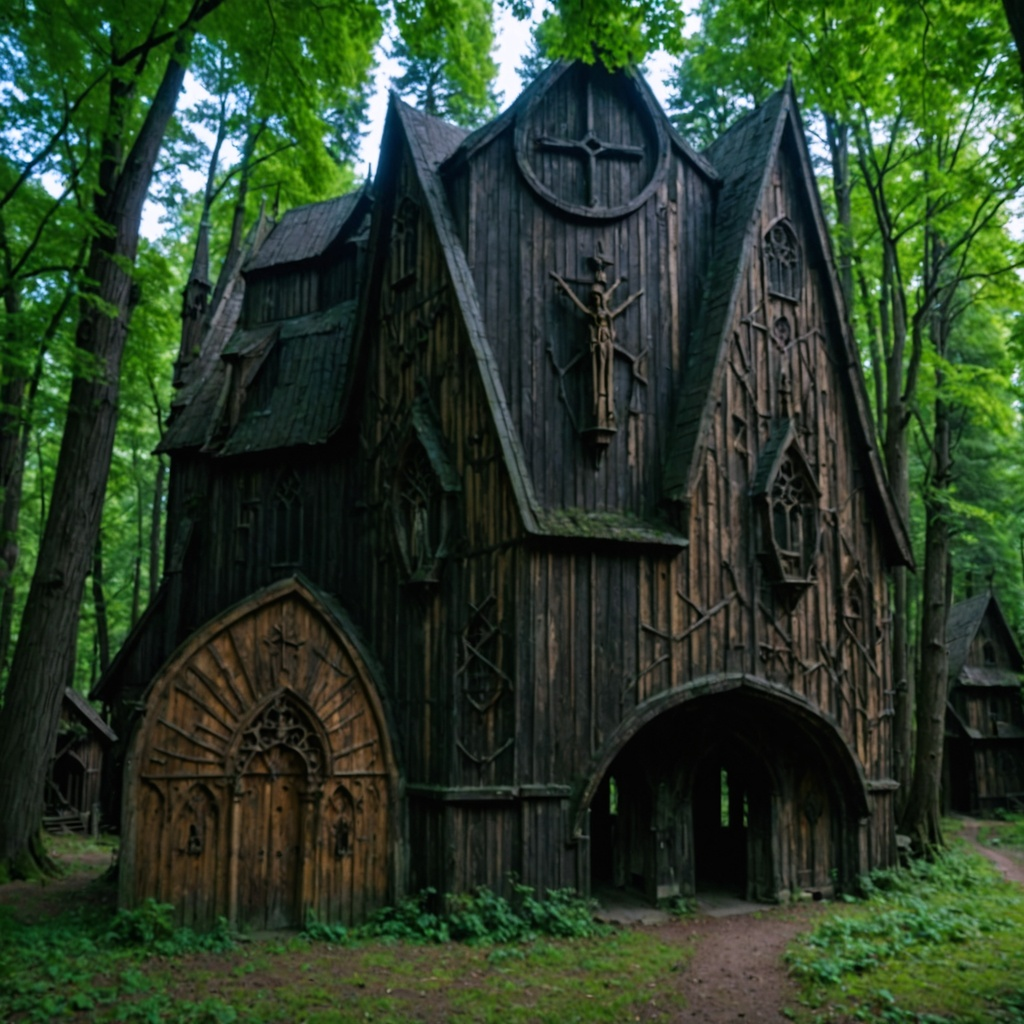

In [ ]:
# Stable Image Sketch

image = "./content/sketch.jpg"  # required {type:"string"}
prompt = "a house with background of mountains and a river flowing nearby"  # required {type:"string<binary>"}
negative_prompt = ""  # {type:"string"}
control_strength = 1  # {type:"slider", min:0, max:1, step:0.05}
seed = 0  # {type:"integer"}
output_format = "jpeg"  # ["webp", "jpeg", "png"]
style_preset = "None"  # ["3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]

model_id = stable_image_control_sketch

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "control_strength": control_strength,
        "image": image_base64,
        "seed": seed,
        "output_format": output_format,
        "prompt": prompt
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Structure 

In [ ]:
# Stable Image Structure

image = "./content/toad.jpg"  # required {type:"string"}
prompt = "a victorian toad covered in gems standing in the forest, looking at the viewer"  # required {type:"string"}
negative_prompt = ""  # {type:"string"}
control_strength = 0.7   # {type:"slider", min:0, max:1, step:0.05}
seed = 0  # [0 .. 4294967294]
output_format = "jpeg"  # ["webp", "jpeg", "png"]
style_preset = "None"  # ["3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]

model_id = stable_image_control_structure

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "control_strength": control_strength,
        "image": image_base64,
        "seed": seed,
        "output_format": output_format,
        "prompt": prompt
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Style Guide

In [ ]:
# Stable Image Style Guide

image = "./content/pastel_landscape.jpg"  # required {type:"string<binary>"}
prompt = "cat in the forest"  # required {type:"string"}
negative_prompt = ""  # {type:"string"}
aspect_ratio = "1:1"  # ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
fidelity = 0.5  # {type:"slider", min:0, max:1, step:0.05}
seed = 0  # {type:"integer"}
output_format = "jpeg"  # ["webp", "jpeg", "png"]
style_preset = "None"  # ["3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]


model_id = stable_image_style_guide

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "fidelity": fidelity,
        "image": image_base64,
        "seed": seed,
        "output_format": output_format,
        "prompt": prompt,
        "aspect_ratio": aspect_ratio
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Style Transfer

Original Image:


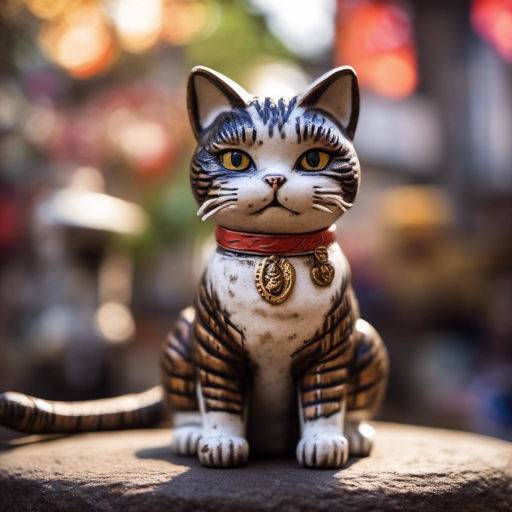

Result Image:


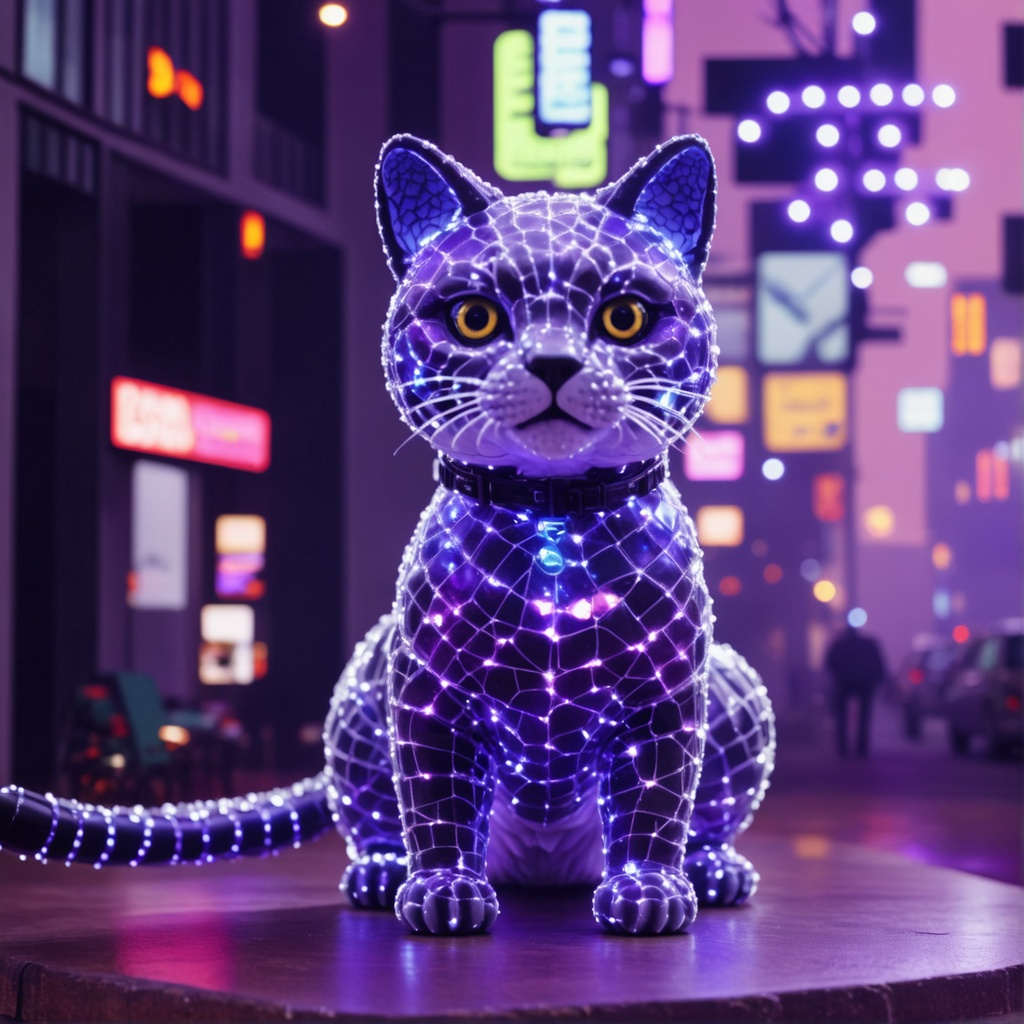

In [13]:
# Stable Image Style Transfer 

init_image = "./content/cat_statue_512x512.jpg"  # required {type:"string<binary>"}
style_image = "./content/glowbot_style.jpg"  # required {type:"string<binary>"}
prompt = ""  # {type:"string"}
negative_prompt = ""  # {type:"string"}
style_strength = 1.0  # {type:"slider", min:0, max:1, step:0.05}
composition_fidelity = 0.9  # {type:"slider", min:0, max:1, step:0.05}
change_strength = 0.9  # {type:"slider", min:0.1, max:1, step:0.05}
seed = 0  # {type:"integer"}
output_format = "jpeg"  # ["webp", "jpeg", "png"]

model_id = stable_image_style_transfer

try:
    init_image_base64 = create_base64_from_image(init_image)
    style_image_base64 = create_base64_from_image(style_image)

    params = {
        "change_strength": change_strength,
        "composition_fidelity": composition_fidelity,
        "output_format": output_format,
        "seed": seed,
        "style_strength": style_strength,
        "init_image": init_image_base64,
        "style_image": style_image_base64
    }

    generated_image = send_generation_request(params, model_id, "us-east-1")

    print("Original Image:")
    display(Image(init_image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

# Upscale Image Services

Stable Image Upscaling services include:

Creative Upscaler: This service will transform a low quality, low resolution image into a stunning work of art with intricate details at 9mp resolution - regardless of the input resolution. Provide an input image of poor quality and add a prompt that describes the desired output. High creativity (up to 0.35) will yield dramatic changes to the image.

Conservative Upscaler: Upgrade low-res to 4k without reinterpreting the image.

Fast Upscaler: Simple, low-cost upscaler to increase image resolution by 4, up to 4 megapixels.

### Stable Image Creative Upscale

In [ ]:
# Stable Image Creative Upscale

image = "./content/bird.jpg"  # required {type:"string"}
prompt = "This dreamlike digital art captures a vibrant, kaleidoscopic bird in a lush rainforest"  # required {type:"string"}
negative_prompt = ""  # {type:"string"}
seed = 0  # {type:"integer"}
creativity = 0.30  # {type:"number"}
output_format = "jpeg"  # ["webp", "jpeg", "png"]
style_preset = "None"  # ["3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]

model_id = stable_image_creative_upscale

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "prompt": prompt,
        "seed": seed,
        "creativity": creativity,
        "image": image_base64,
        "output_format": output_format
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Conservative Upscale


In [ ]:
# Stable Image Conservative Upscale

image = "./content/chicken.png"  # required {type:"string"}
prompt = "photo of a giant chicken in a forest"  # required {type:"string"}
negative_prompt = ""  # {type:"string"}
seed = 0  # {type:"integer"}
creativity = 0.35  # {type:"number"}
output_format = "jpeg"  # ["webp", "jpeg", "png"]

model_id = stable_image_conservative_upscale

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "prompt": prompt,
        "seed": seed,
        "creativity": creativity,
        "image": image_base64,
        "output_format": output_format
    }

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Fast Upscale

In [ ]:
# Stable Image Fast Upscale

image = "./content/cat_statue_512x512.jpg"  # required {type:"string"}
output_format = "jpeg"  # ["webp", "jpeg", "png"]

model_id = stable_image_fast_upscale

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "image": image_base64,
        "output_format": output_format
    }

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

# Edit Image Services
Stable Image editing services include four offerings currently in production:

- Inpaint: where you specify a `mask` (or use the alpha channel of the `image` parameter). The `prompt` is what will be added to the image in the masked area. Regardless of input resolution, the output will be provided at 4mp.
- Outpaint: Extend an image in any direction.
- Search-and-Recolor: where you specify what you want to recolor in the input image via `select_prompt`. The `prompt` is what will be added to the image in place of the object from the select_prompt. The resolution of the generated image will match the resolution of the input image.
- Search-and-Replace: where you specify what you want to replace in the input image via `search_prompt`. The `prompt` is what will be added to the image in place of the object from the search_prompt. Regardless of input resolution, the output will be provided at 4mp.
- Erase: Remove unwanted objects, such as blemishes on portraits or items on desks, using image masks.
- Remove Background: Removes the background from an image.
- Replace Background and Relight: Swap backgrounds with AI-generated or uploaded images while adjusting lighting to match the subject. 

### Stable Image Inpaint 

Original Image:


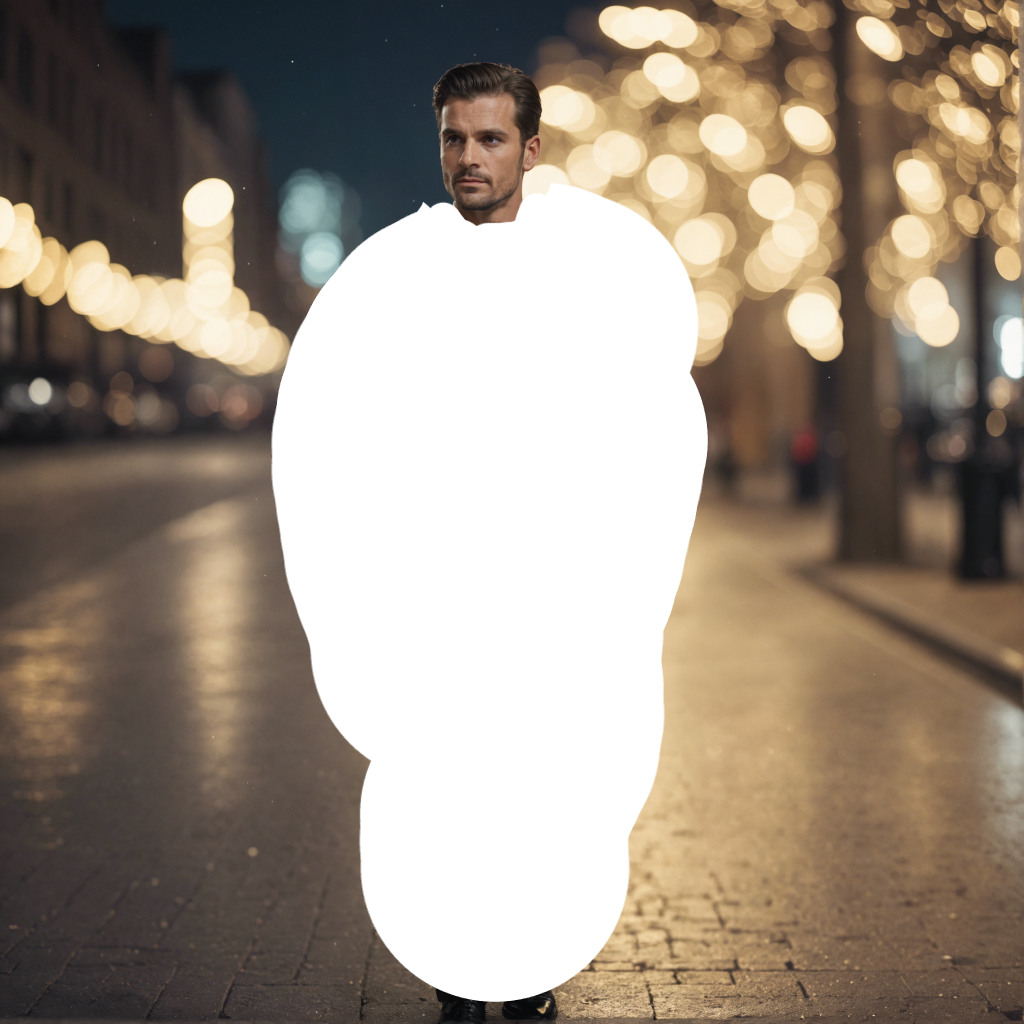

Result Image:


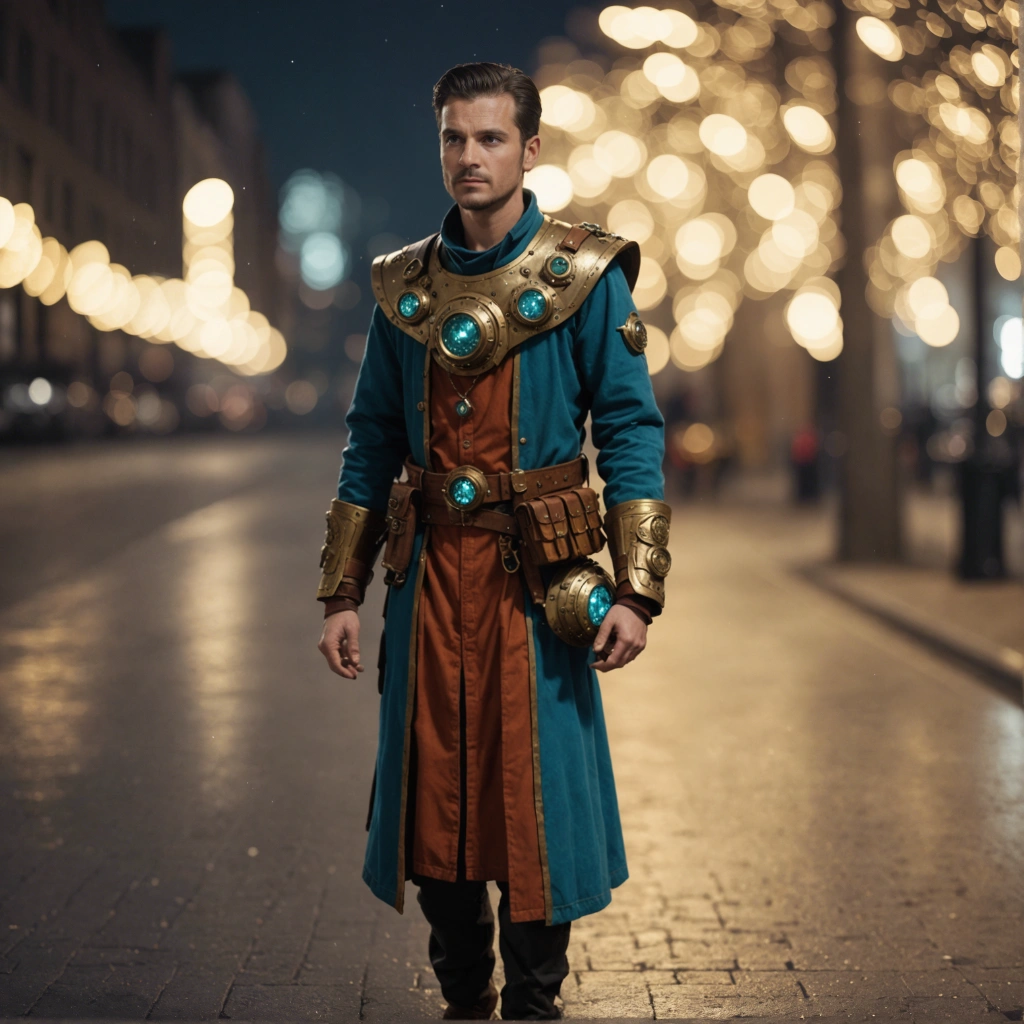

In [17]:
# Stable Image Inpaint

image = "./content/tux.png"  # required {type:"string<binary>"}
prompt = "artificer of time and space"  # required {type:"string"}
mask = None  # type:"string<binary>"}
grow_mask = ""  # [0 .. 100]
negative_prompt = ""  # {type:"string"}
seed = 0  # {type:"integer"}
output_format = "webp"  # ["webp", "jpeg", "png"]
style_preset = "None"  # ["3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]

model_id = stable_image_inpaint

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "image": image_base64,
        "seed": seed,
        "output_format": output_format,
        "prompt": prompt
    }

    if mask is not None:
        mask_image_base64 = create_base64_from_image(mask)
        params["mask"] = mask_image_base64

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Outpaint

In [ ]:
# Stable Image Outpaint

image = "./content/chicken.png"  # required {type:"string<binary>"} must include left or right or up or down
left = 512  # {type:"number"} [0 .. 2000]
right = 512  # {type:"number"}[0 .. 2000]
up = 200  # {type:"number"} [0 .. 2000]
down = 100  # {type:"number"} [0 .. 2000]
prompt = ""  # {type:"string"}
creativity = 0.5  # {type:"number"} [0..1]
seed = 0  # {type:"integer"} [0 .. 4294967294]
output_format = "webp"  # ["webp", "jpeg", "png"]
style_preset = "None"  # ["3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]

model_id = stable_image_outpaint

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "image": image_base64,
        "left": left,
        "right": right,
        "up": up,
        "down": down,
        "creativity": creativity,
        "seed": seed,
        "output_format": output_format
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Search and Recolor

Original Image:


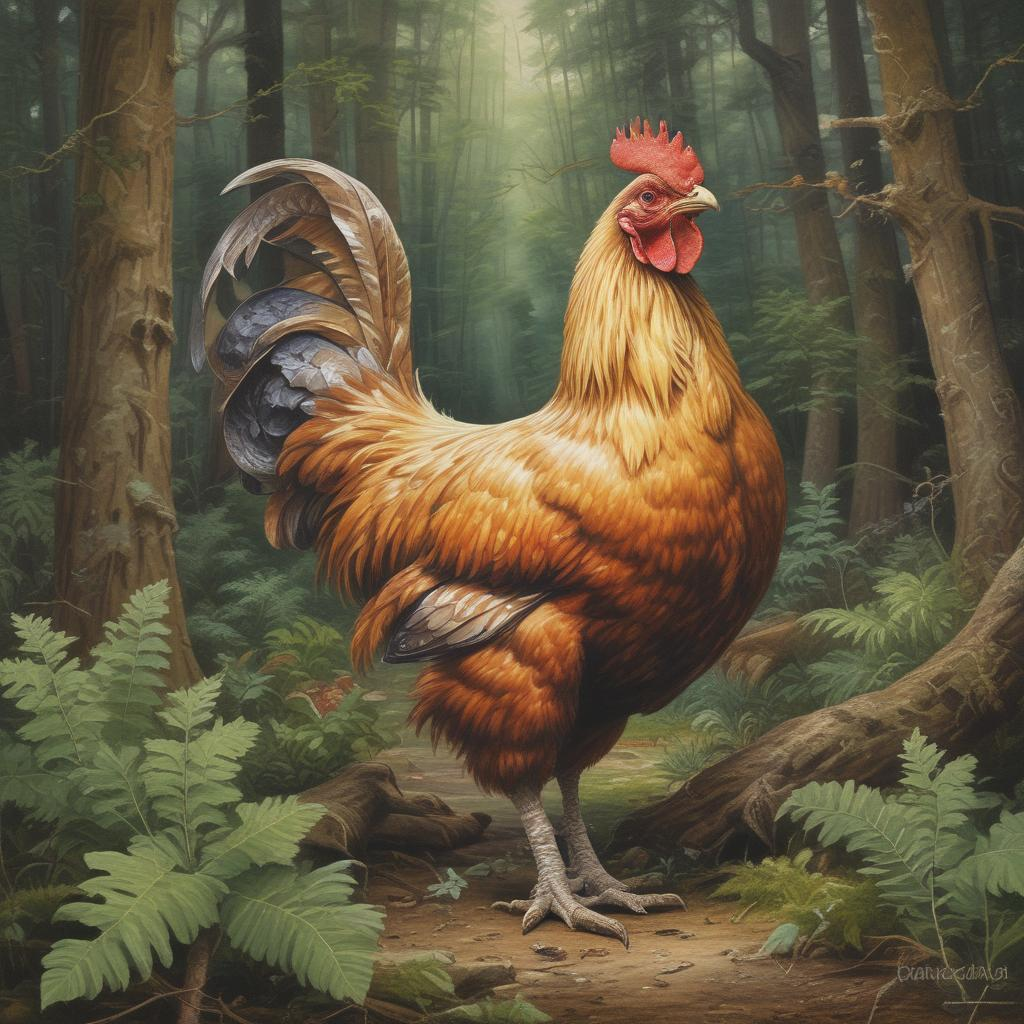

Result Image:


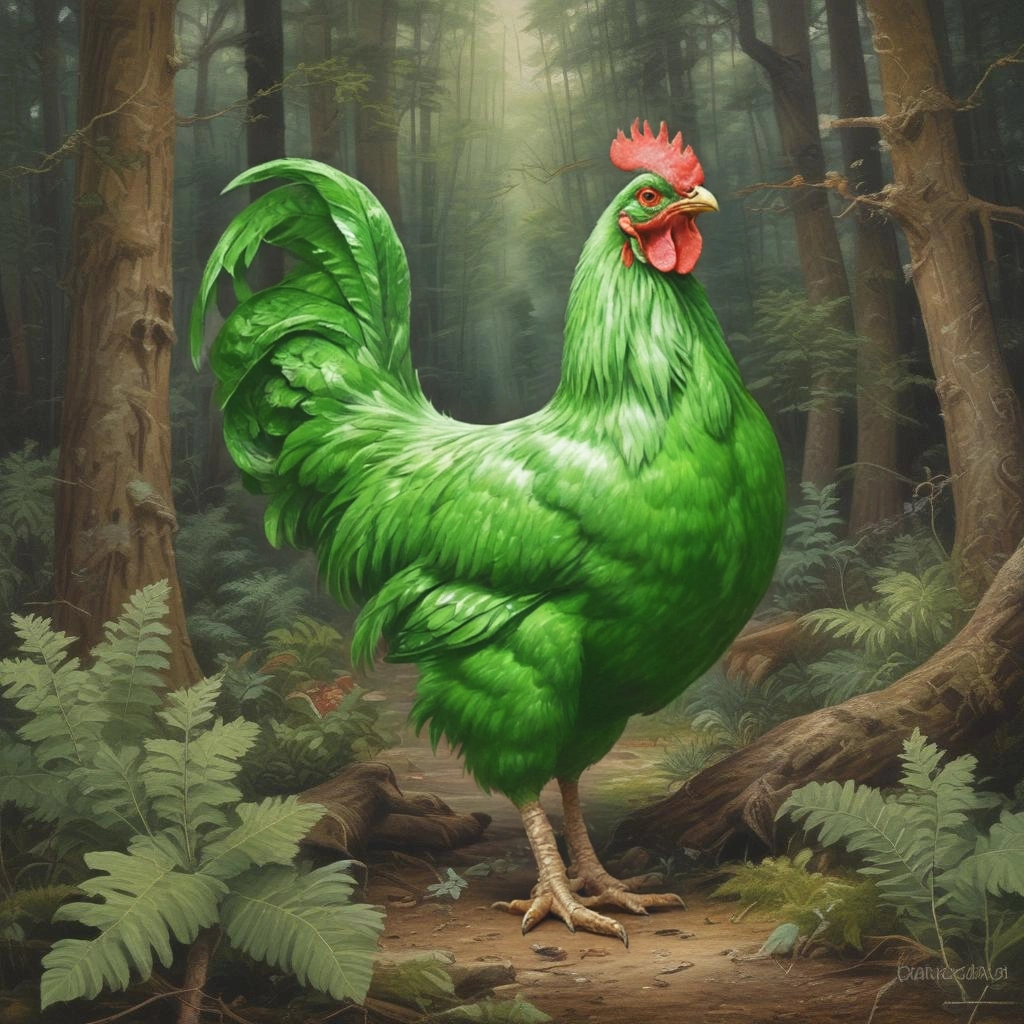

In [19]:
# Stable Image Search and Recolor

image = "./content/chicken.png"  # required {type:"string<binary>"}
prompt = "green chicken"  # required{type:"string"}
select_prompt = "chicken"  # required{type:"string"}
negative_prompt = ""  # {type:"string"}
grow_mask = 3  # {type:"integer"}
seed = 0  # {type:"integer"}
output_format = "webp"  # ["webp", "jpeg", "png"]
style_preset = "None"  # ["3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]

model_id = stable_image_search_recolor

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "image": image_base64,
        "grow_mask": grow_mask,
        "seed": seed,
        "output_format": output_format,
        "prompt": prompt,
        "select_prompt": select_prompt
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Search and Replace

In [ ]:
# Stable Image Search and Replace

image = "./content/chicken.jpg"  # required {type:"string<binary>"}
prompt = "a victorian queen standing in the forest, looking at the viewer"  # required {type:"string"}
search_prompt = "chicken"  # required {type:"string"}
negative_prompt = ""  # {type:"string"}
seed = 0  # {type:"integer"}
output_format = "webp"  # ["webp", "jpeg", "png"]
grow_mask = 3  # [0 .. 20]
style_preset = "None"  # ["3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]

model_id = stable_image_search_replace

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "image": image_base64,
        "seed": seed,
        "output_format": output_format,
        "prompt": prompt,
        "search_prompt": search_prompt,
    }

    if style_preset != "None":
        params["style_preset"] = style_preset

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Erase

In [ ]:
# Stable Image Erase

image = "./content/island.png"  # {type:"string<binary>"}
mask = None  # {type:"string<binary>"}
seed = 0  # {type:"integer"}
output_format = "webp"  # ["webp", "jpeg", "png"]
grow_mask = 3  # [0 .. 20]

model_id = stable_image_erase_object

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "image": image_base64,
        "output_format": output_format,
        "seed": seed
    }

    if mask is not None:
        mask_image_base64 = create_base64_from_image(mask)
        params["mask"] = mask_image_base64

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)

### Stable Image Remove Background

In [ ]:
# Stable Image Remove Background

image = "./content/img.png"  # required {type:"string<binary>"}
output_format = "webp"  # ["webp", "jpeg", "png"]

model_id = stable_image_remove_bg

try:
    image_base64 = create_base64_from_image(image)

    params = {
        "image": image_base64,
        "output_format": output_format
    }

    generated_image = send_generation_request(params, model_id, region)

    print("Original Image:")
    display(Image(image))

    print("Result Image:")
    display(Image(data=generated_image))

except Exception as e:
    print(e)